# Setup and Exploratory Data Analysis

In [1]:
#Import necessary libraries
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math

from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
#Function aggregates importance of categorical variables together and removes individual categoricals from target df
def Aggregate_Categoricals(Target_df, String_ID):
    filtered_df = Target_df[Target_df['Feature'].str.startswith(String_ID)]
    Target_df = Target_df[~Target_df['Feature'].str.startswith(String_ID)]

    NewRow = pd.DataFrame({'Feature':[String_ID],'Importance':[filtered_df['Importance'].sum()]})
    
    Target_df = pd.concat([Target_df,NewRow])

    return Target_df

In [3]:
pd.options.mode.chained_assignment = None 

#Import csv data
df = pd.read_csv(r'stores_sales_forecasting.csv', encoding='ISO-8859-1')

In [4]:
#Describe series of interest
print('Profit description:\n' + str(df['Profit'].describe()))
print('\nSales description:\n' + str(df['Sales'].describe()))
print('\nDiscount description:\n' + str(df['Discount'].describe()))

#Show data head
df.head()

Profit description:
count    2121.000000
mean        8.699327
std       136.049246
min     -1862.312400
25%       -12.849000
50%         7.774800
75%        33.726600
max      1013.127000
Name: Profit, dtype: float64

Sales description:
count    2121.000000
mean      349.834887
std       503.179145
min         1.892000
25%        47.040000
50%       182.220000
75%       435.168000
max      4416.174000
Name: Sales, dtype: float64

Discount description:
count    2121.000000
mean        0.173923
std         0.181547
min         0.000000
25%         0.000000
50%         0.200000
75%         0.300000
max         0.700000
Name: Discount, dtype: float64


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [5]:
#Check if we can use Order ID alone as a primary key (by inspection we cannot but good to verify)

if df['Order ID'].is_unique:
    print('Order ID is an appropriate primary key')
else:
    print('Order ID is not an appropriate primary key')

Order ID is not an appropriate primary key


In [6]:
#Order ID alone is insufficient because of duplicates
#Combining Order ID with Product ID might work

df['Primary Key'] = df['Order ID'] + '-' + df['Product ID']

#Perform sanity check to verify primary key is indeed unique (has to match length of dataframe)
if df['Primary Key'].is_unique:
    print('Primary Key is unique')
else:
    print('Dataframe length (' + str(len(df)) + ') is not equal to Primary Key length (' \
          + str(df['Primary Key'].nunique()) + ')\n')

    #Show duplicates
    duplicates = df[df.duplicated(subset=['Primary Key'])]
    print(duplicates)


Dataframe length (2121) is not equal to Primary Key length (2119)

     Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
270    1302  CA-2016-137043  12/23/2016  12/25/2016    Second Class   
720    3407  US-2014-150119   4/23/2014   4/27/2014  Standard Class   

    Customer ID   Customer Name      Segment        Country         City  ...  \
270    LC-17140    Logan Currie     Consumer  United States  Springfield  ...   
720    LB-16795  Laurel Beltran  Home Office  United States     Columbus  ...   

    Region       Product ID   Category Sub-Category  \
270  South  FUR-FU-10003664  Furniture  Furnishings   
720   East  FUR-CH-10002965  Furniture       Chairs   

                                          Product Name    Sales Quantity  \
270  Electrix Architect's Clamp-On Swing Arm Lamp, ...  286.380        3   
720  Global Leather Highback Executive Chair with P...  281.372        2   

     Discount   Profit                     Primary Key  
270       0.0  83.0502 

In [7]:
#There are two instances where Order ID and Product ID are identical, so our Primary Key is not unique
#These appear legitimate entries as opposed to unintentionally duplicated rows, so we can't just drop them
#Instead, I will add an artificial index onto the end which should guarantee unique keys

df['Index Only'] = df.index + 1
df['Primary Key'] = df['Primary Key'] + '-' + df['Index Only'].astype(str)

#Verify primary key is unique
print('Primary Key Unique: ' + str(df['Primary Key'].is_unique) + '\n')

#Drop unneccessary columns
df = df.drop(columns=['Row ID'])
df = df.drop(columns=['Index Only'])

Primary Key Unique: True



## Profit Trends

Annual profits ($):
Year
2014    5457.7255
2015    3015.2029
2016    6959.9531
2017    3018.3913


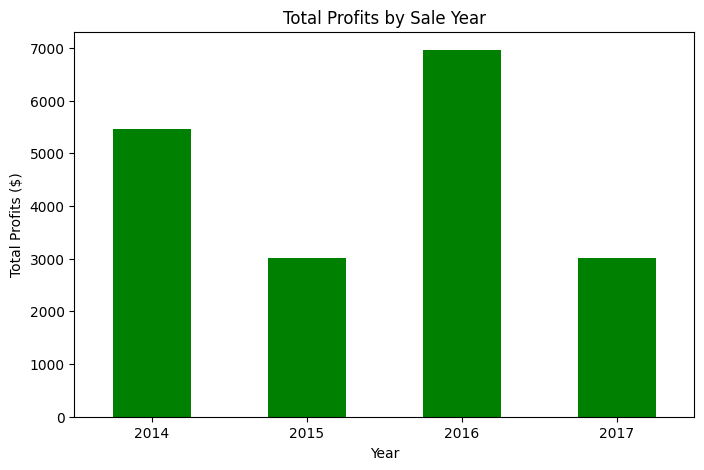

In [8]:
#Check sum of profits by sale year
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year

print('Annual profits ($):')
yearly_profits = df.groupby('Year')['Profit'].sum()
print(yearly_profits.to_string())

plt.figure(figsize=(8, 5))
yearly_profits.plot(kind='bar', color='green')
plt.title('Total Profits by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(rotation=0)
plt.show()

In [9]:
#Cutoff profit outliers at 3 standard devs for histogram plotting

cutoff = 3
Lbound = df['Profit'].mean() - cutoff*df['Profit'].std()
Ubound = df['Profit'].mean() + cutoff*df['Profit'].std()

df_no_outliers = df[(df['Profit'] > Lbound) & (df['Profit'] < Ubound)]
Low_Outliers = df[(df['Profit'] < Lbound)]
High_Outliers = df[(df['Profit'] > Ubound)]

#Determine total outliers and how many are high vs. low
print('Number of outliers removed: ' + str(len(df) - len(df_no_outliers))+' out of ' + str(len(df)) + ' rows')
print('Number of outliers above ' + str(cutoff) + ' standard devs: ' + str(len(High_Outliers)))
print('Number of outliers below ' + str(cutoff) + ' standard devs: ' + str(len(Low_Outliers)) +'\n')


Number of outliers removed: 44 out of 2121 rows
Number of outliers above 3 standard devs: 19
Number of outliers below 3 standard devs: 25



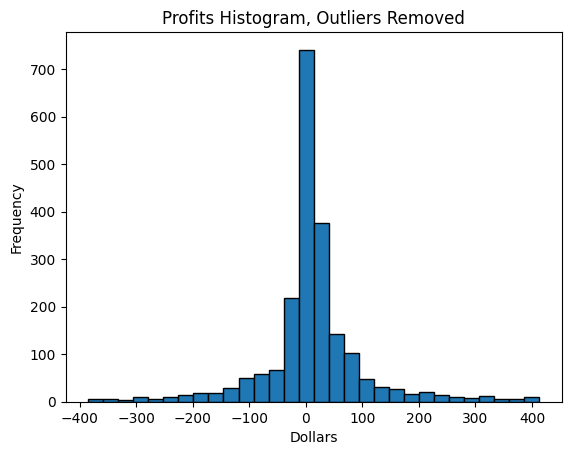

In [10]:
#Plot histogram of profits without outliers to look for recognizable distribution
plt.hist(df_no_outliers['Profit'],bins=30, edgecolor='black')
plt.title('Profits Histogram, Outliers Removed')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.show()

In [11]:
#Test if this is close to a Normal Distribution with a Shapiro-Wilk test (probably not)
stat, p_value = stats.shapiro(df_no_outliers['Profit'])

print('P-value is: ' + str(round(p_value,5)))
if p_value > 0.05:
    print('There is insufficient evidence this data does not follow a normal distribution.')
else:
    print('The data does not conform to a normal distribution.')

P-value is: 0.0
The data does not conform to a normal distribution.


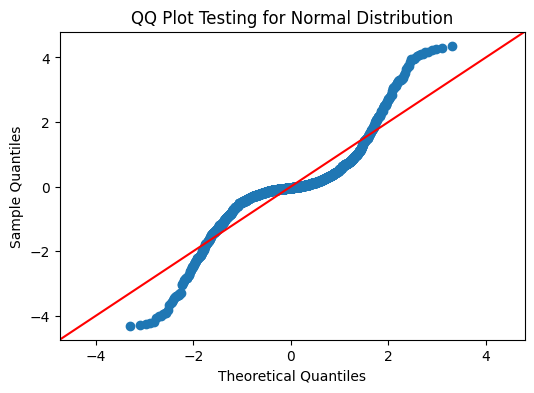

In [12]:
#Verify shapiro-wilk result with a QQ test
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(df_no_outliers['Profit'],stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot Testing for Normal Distribution')
plt.show()

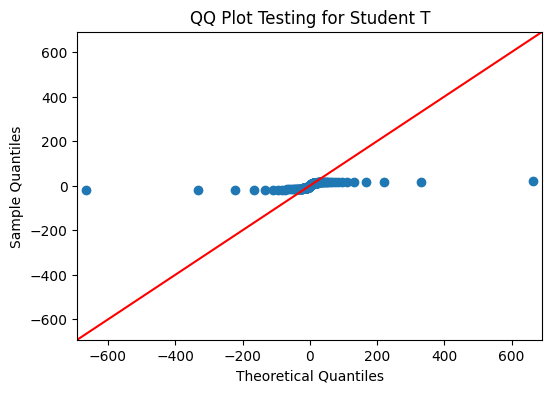

In [13]:
#Test for Student T distribution (profit distribution has heavy tails so may be a better fit)
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(df_no_outliers['Profit'],stats.t, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot Testing for Student T')
plt.show()

## Sales Trends

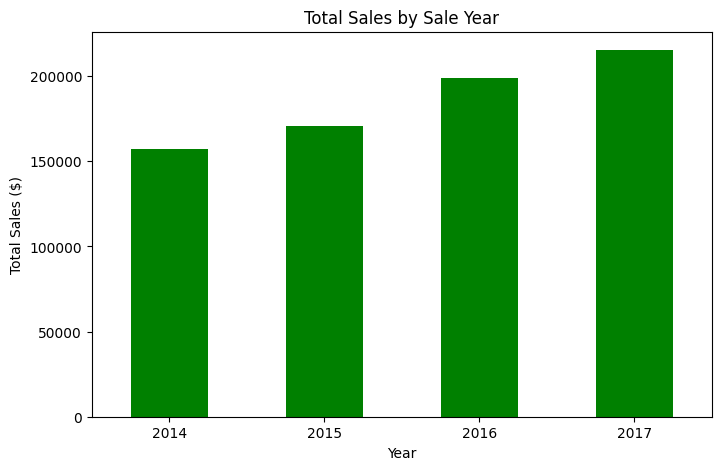

In [14]:
#Check sum of sales by year
yearly_sales = df.groupby('Year')['Sales'].sum()

plt.figure(figsize=(8, 5))
yearly_sales.plot(kind='bar', color='green')
plt.title('Total Sales by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=0)
plt.show()

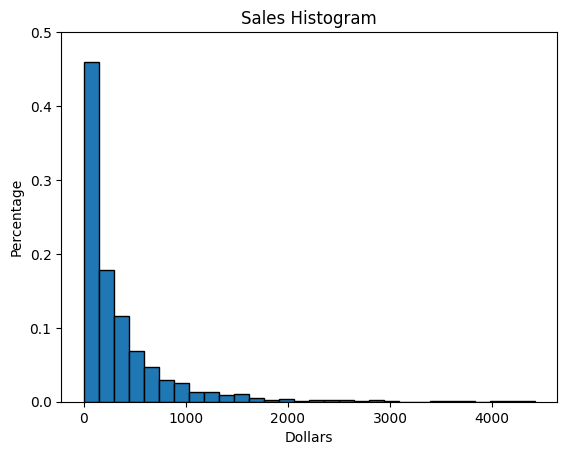

In [15]:
#Check distribution of sales with histogram
plt.hist(df['Sales'],bins=30, edgecolor='black',weights=np.ones(len(df['Sales']))/len(df['Sales']))
plt.title('Sales Histogram')
plt.ylim(0, 0.5)
plt.xlabel('Dollars')
plt.ylabel('Percentage')
plt.show()

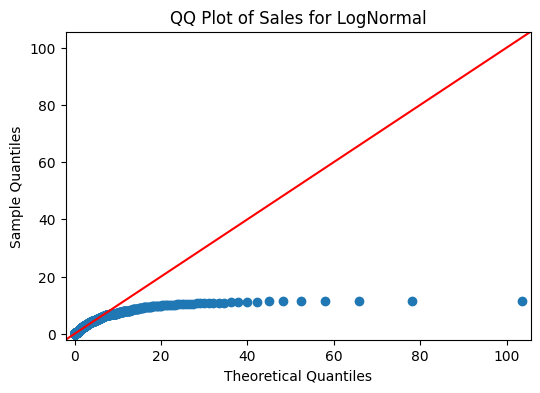

In [16]:
#Quick check if Sales follow a log-normal distribution
Sales_Filtered = df['Sales'][df['Sales'] < 3*df['Sales'].std()]

fig,ax=plt.subplots(figsize = (6,4))
sm.qqplot(Sales_Filtered,stats.lognorm,line='45',fit=True, ax=ax)
ax.set_title('QQ Plot of Sales for LogNormal')
plt.show()

## Categorical Trends

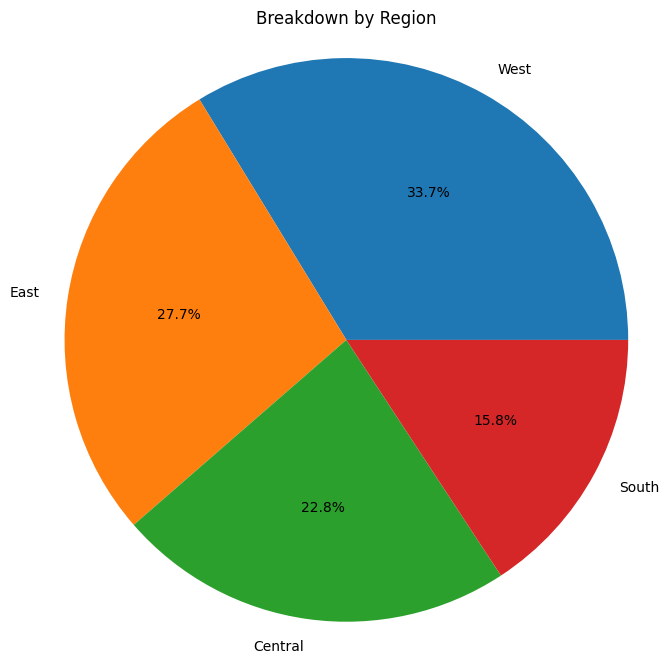

In [17]:
#Check breakdown by region, removing duplicate order IDs to avoid double-counting those orders
df_no_dupes = df.drop_duplicates(subset=['Order ID'])
Region_counts = df_no_dupes['Region'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(Region_counts,labels=Region_counts.index,autopct='%1.1f%%')
plt.title('Breakdown by Region')
plt.axis('equal')
plt.show()

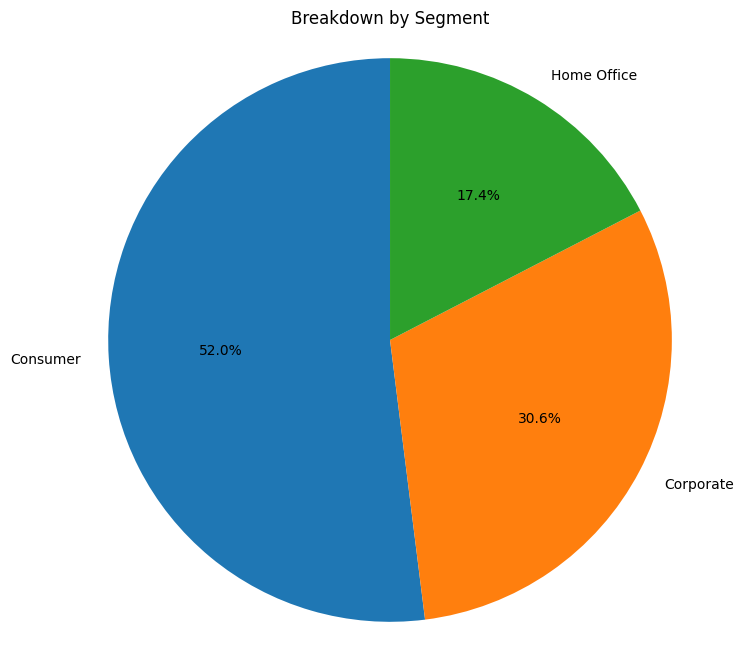

In [18]:
#Check breakdown by product segment
Segments = df_no_dupes['Segment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(Segments,labels=Segments.index,autopct='%1.1f%%',startangle=90)
plt.title('Breakdown by Segment')
plt.axis('equal')
plt.show()

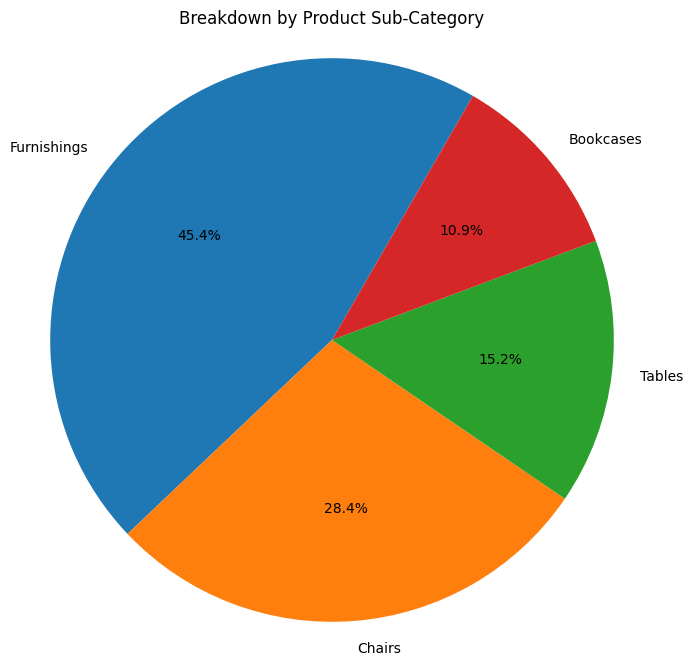

In [19]:
#Check breakdown by product sub-category

Sub_categories = df_no_dupes['Sub-Category'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(Sub_categories,labels=Sub_categories.index,autopct='%1.1f%%',startangle=60)
plt.title('Breakdown by Product Sub-Category')
plt.axis('equal')
plt.show()

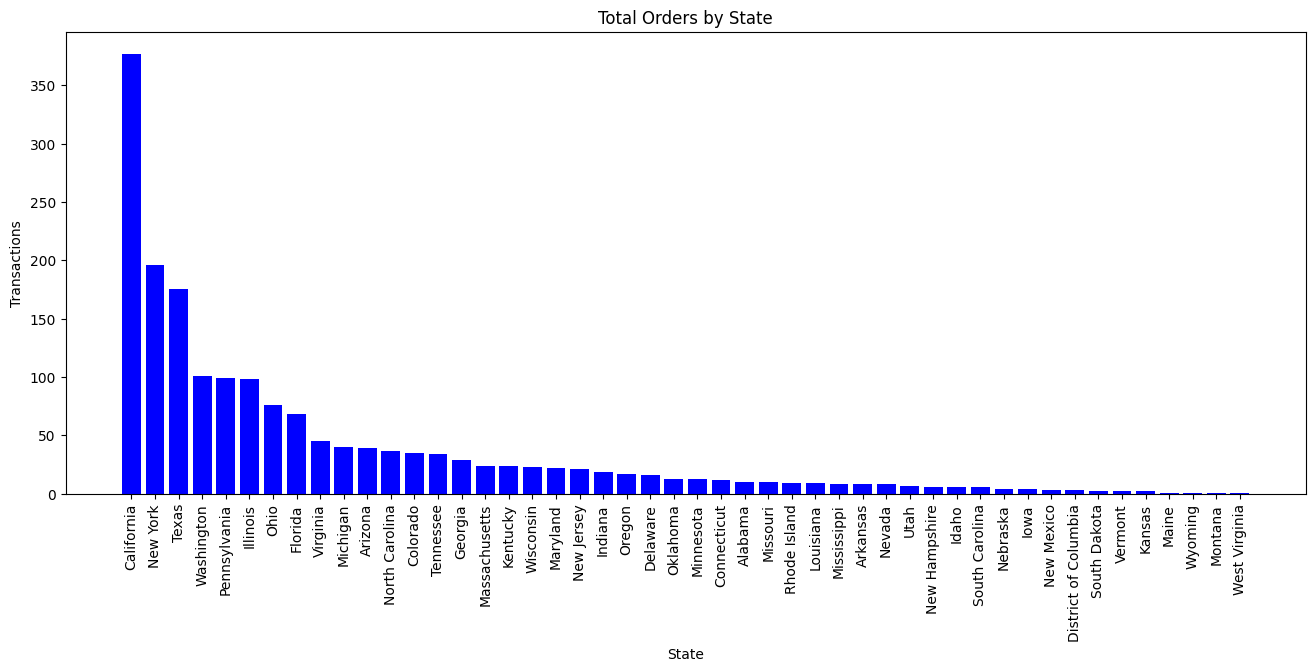

In [20]:
#Create bar graph of orders by state

States = df_no_dupes['State'].value_counts()

plt.figure(figsize=(16,6))
plt.bar(States.index,States.values,color='blue')
plt.title('Total Orders by State')
plt.xlabel('State')
plt.ylabel('Transactions')
plt.xticks(rotation=90)
plt.show()

# Further Profit Trend Analysis

## Hypothesis Testing

count    2121.000000
mean        3.878353
std        34.452956
min      -210.000000
25%        -7.142857
50%        11.111111
75%        27.500000
max        50.000000
Name: Profit Margin, dtype: float64
count    2121.000000
mean      113.967558
std       123.187852
min         1.740000
25%        19.940000
50%        71.370000
75%       160.980000
max       880.980000
Name: Unit Price, dtype: float64


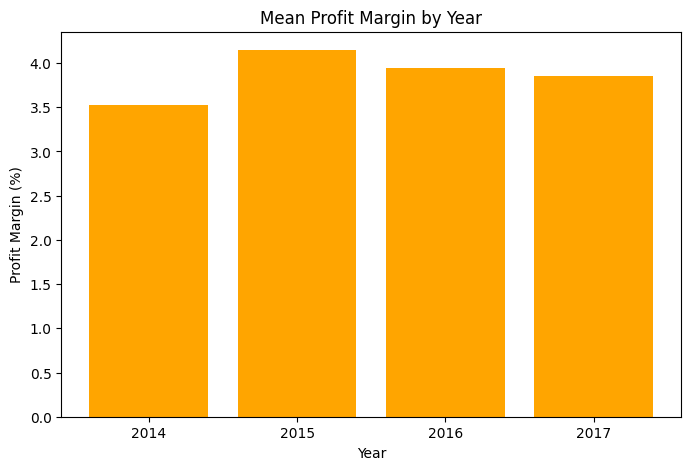

In [21]:
#As previously observed, overall (summed) profits in 2015 and 2017 are much lower than in 2014 and 2016
#This does not seem correlated to total sales for the respective years, and no cause readily presents itself
#The aim of this section is to test several hypotheses for what is causing the profit fluctuations

#Create additional features
df['Profit Margin'] = df['Profit']/df['Sales']*100
df['Unit Price'] = df['Sales']/(df['Quantity']*(1-df['Discount']))

print(df['Profit Margin'].describe())
print(df['Unit Price'].describe())

#Plot mean profit margins to see if they match total profits
yearly_profit_margin = df.groupby('Year')['Profit Margin'].mean()

plt.figure(figsize=(8, 5))
plt.bar(yearly_profit_margin.index, yearly_profit_margin.values, color='orange')
plt.title('Mean Profit Margin by Year')
plt.xlabel('Year')
plt.ylabel('Profit Margin (%)')
plt.xticks(yearly_profit_margin.index.astype(int))
plt.show()

Mean discount in 2014 is: 0.182
Mean discount in 2015 is: 0.169
Mean discount in 2016 is: 0.177
Mean discount in 2017 is: 0.17


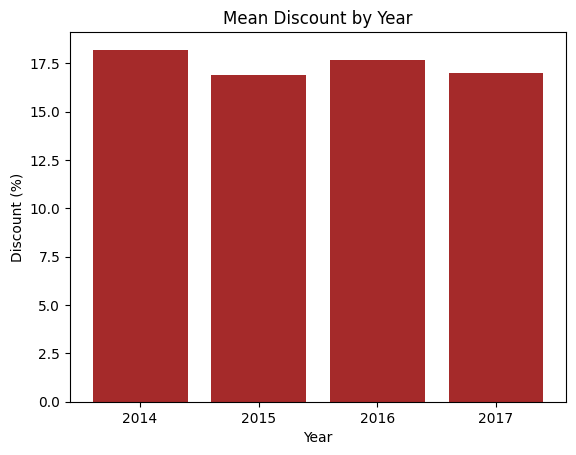

In [22]:
#Hypothesis: frivolous discounts are responsible for lower profits in 2015 and 2017. 
#Let's compare the mean discounts each year and see how they differ.

yearly_discounts = df.groupby('Year')['Discount'].mean()
plt.bar(yearly_discounts.index, 100*yearly_discounts.values, color='brown')
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel('Year')
plt.ylabel('Discount (%)')
plt.title('Mean Discount by Year')

i = 2014

for value in yearly_discounts:
    print('Mean discount in ' + str(i) + ' is: ' + str(round(value,3)))
    i += 1

plt.show()

The slope of the linear regression line is: -168.47
The Pearson correlation coefficient is: -0.89


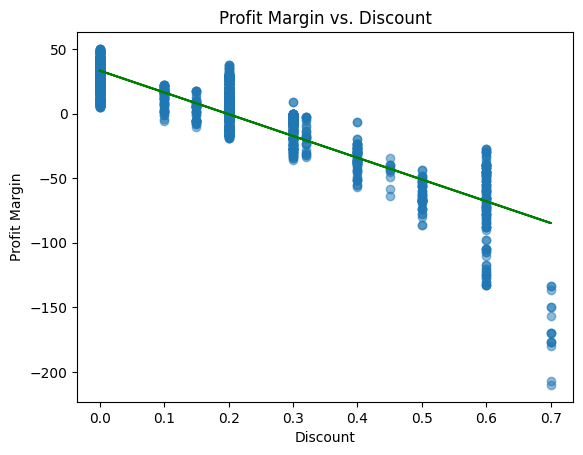

In [23]:
#Discounts do not appear to be the cause behind profit fluctuations, in fact 2015 and 2017 had lower mean discounts

#Perform linear regression between discount and profit margin (should be very negative slope)
slope, intercept = np.polyfit(df['Discount'],df['Profit Margin'],1)
predicted_profit = np.polyval([slope, intercept],df['Discount'])

print('The slope of the linear regression line is: ' + str(round(slope,2)))

#Check Pearson correlation coefficient (Less than -0.5 is a strong negative correlation)
corr_coef = np.corrcoef(df['Discount'],df['Profit Margin'])[0,1]
print('The Pearson correlation coefficient is: ' + str(round(corr_coef,2)))

#Plot scatter against regression line
plt.scatter(df['Discount'],df['Profit Margin'],alpha=.5)
plt.plot(df['Discount'],predicted_profit,color='green')
plt.xlabel('Discount')
plt.ylabel('Profit Margin')
plt.title('Profit Margin vs. Discount')
plt.show()

Mean sales value in 2014 is: 373.38
Mean sales value in 2015 is: 377.253
Mean sales value in 2016 is: 353.917
Mean sales value in 2017 is: 313.976


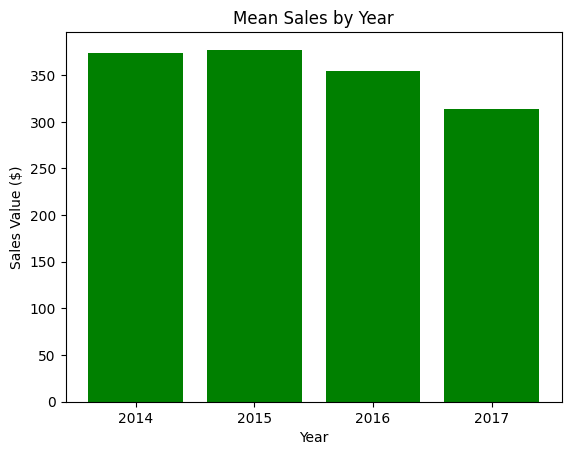

In [24]:
#This confirms the expected discount-profit relationship but still does not explain annual profit fluctuations
#Hypothesis: the mean sales values are lower in years with lower total profits

yearly_mean_sales = df.groupby('Year')['Sales'].mean()

i = 2014

for value in yearly_mean_sales:
    print('Mean sales value in ' + str(i) + ' is: ' + str(round(value,3)))
    i += 1

plt.bar(yearly_mean_sales.index,yearly_mean_sales.values,color='green')
plt.xticks(yearly_mean_sales.index.astype(int))
plt.xlabel('Year')
plt.ylabel('Sales Value ($)')
plt.title('Mean Sales by Year')

plt.show()

Overall transaction count in 2014 is: 421 transactions.
Overall transaction count in 2015 is: 452 transactions.
Overall transaction count in 2016 is: 562 transactions.
Overall transaction count in 2017 is: 686 transactions.


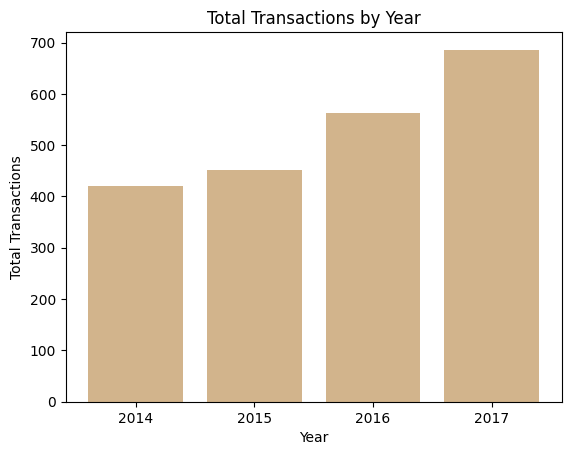

In [25]:
#Mean sales values do not appear to explain profit trends either

#Hypothesis: years with higher profits simply have more total transactions

Transactions_Yearly_Count = df['Year'].value_counts().sort_index()

i = 2014

for value in Transactions_Yearly_Count:
    print('Overall transaction count in ' + str(i) + ' is: ' + str(round(value,3)) + ' transactions.')
    i += 1

plt.bar(Transactions_Yearly_Count.index, Transactions_Yearly_Count.values,color='tan')
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel('Year')
plt.ylabel('Total Transactions')
plt.title('Total Transactions by Year')
plt.show()

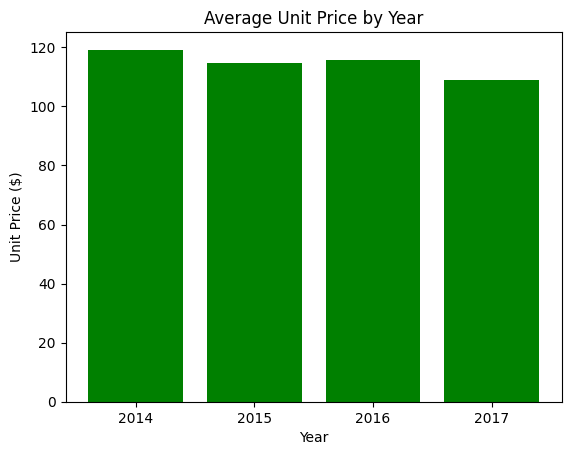

In [26]:
#Total transactions also do not seem to correlate with annual profits

#Hypothesis: goods sold in lower-profit years have lower individual prices
Price_by_year = df.groupby('Year')['Unit Price'].mean()
plt.bar(Price_by_year.index, Price_by_year.values,color='green')  
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel('Year')
plt.ylabel('Unit Price ($)')
plt.title('Average Unit Price by Year')
plt.show()

## Regional Profit Trends

    Region  Profit Margin
0  Central     -18.583641
1     East       9.238888
2    South      14.166165
3     West       9.772249


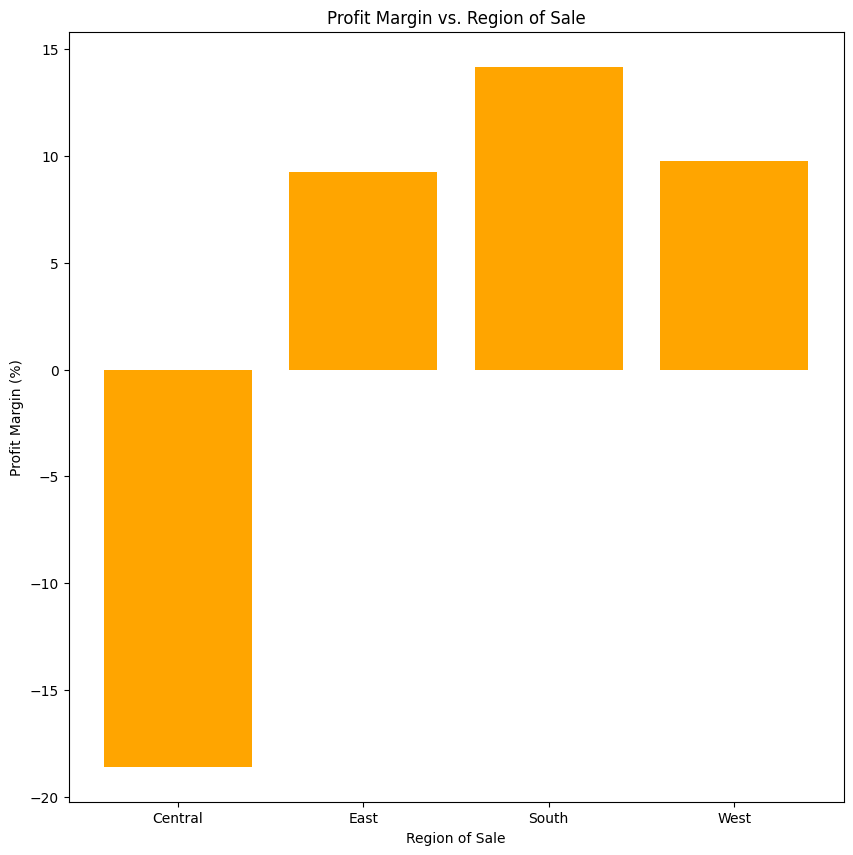

In [27]:
#Let's shift gears and take a look at regional profit trends to see what patterns emerge

df_by_region = df.groupby('Region')['Profit Margin'].mean().reset_index()

print(df_by_region.head())

#Plot profits by region
plt.figure(figsize=(10,10))
plt.bar(df_by_region['Region'],df_by_region['Profit Margin'],color='orange')
plt.xlabel('Region of Sale')
plt.ylabel('Profit Margin (%)')
plt.title('Profit Margin vs. Region of Sale')
plt.show()

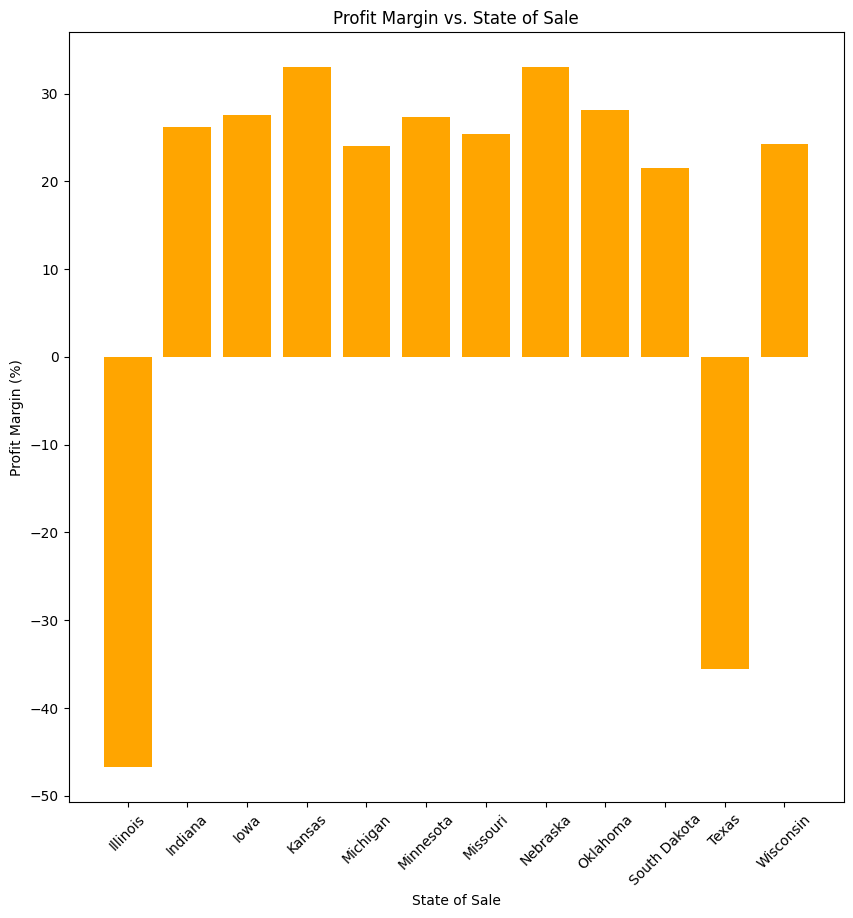

In [28]:
#It looks like all regions are profitable except for Central, so lets look at the individual central states
central_df = df.loc[df['Region']=='Central']

#Group profits in new central-only df by state and reindex
central_df_profits_by_state = central_df.groupby('State')['Profit Margin'].mean().reset_index()

#Plot results
plt.figure(figsize=(10,10))
plt.bar(central_df_profits_by_state['State'],central_df_profits_by_state['Profit Margin'],color='orange')
plt.xticks(rotation=45)
plt.xlabel('State of Sale')
plt.ylabel('Profit Margin (%)')
plt.title('Profit Margin vs. State of Sale')
plt.show()

Central Region Orders by State:
State
Texas           175
Illinois         98
Michigan         40
Wisconsin        23
Indiana          19
Minnesota        13
Oklahoma         13
Missouri         10
Iowa              4
Nebraska          4
South Dakota      2
Kansas            2


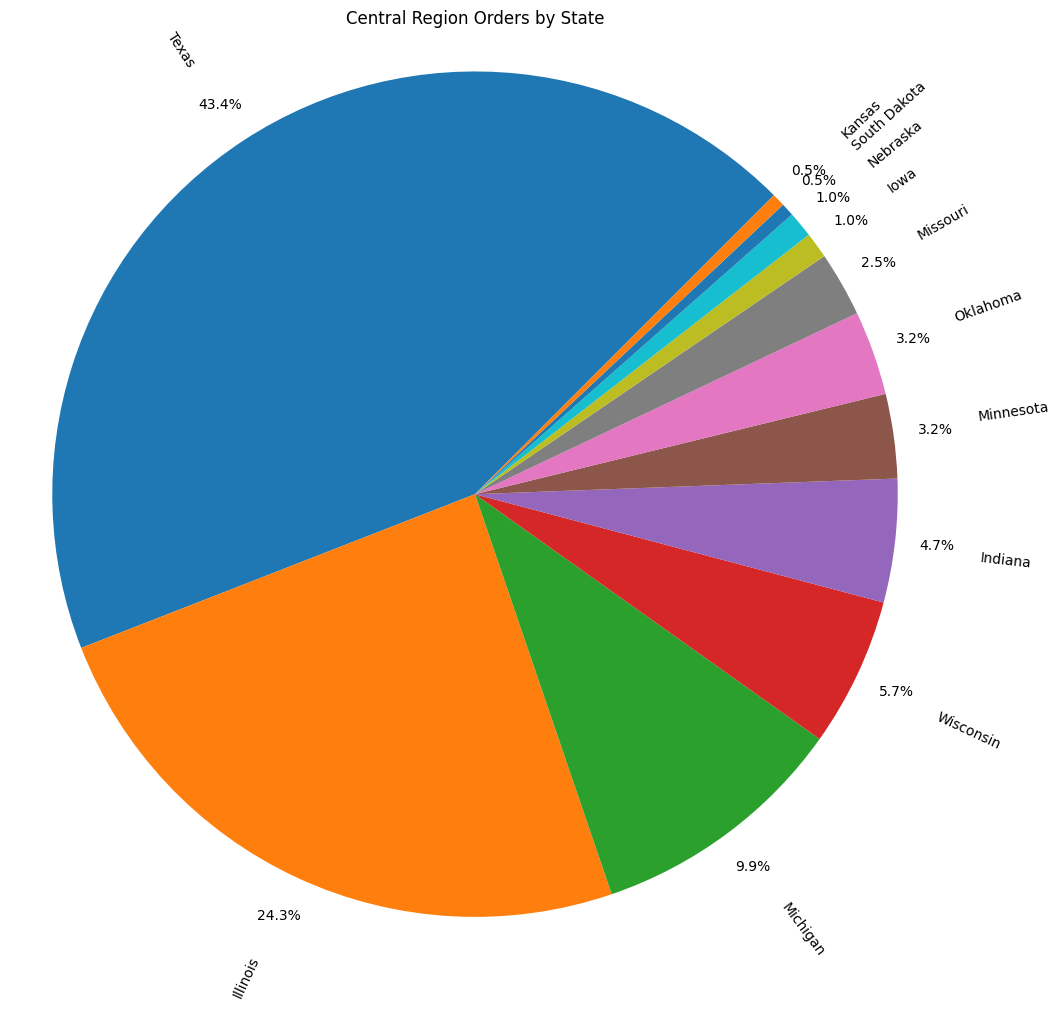

In [29]:
#Within the Central region, all states except Illinois and Texas are profitable
#Let's check what percent of orders they contribute to the region with a pie chart;
#together I would expect they comprise a majority of orders in the region

#Drop duplicate Order IDs
central_df_unique = central_df.drop_duplicates(subset=['Order ID'])
state_counts = central_df_unique['State'].value_counts()

#Print out five most high-order states
print('Central Region Orders by State:')
print(state_counts.to_string())

#Plot results as pie chart
plt.figure(figsize=(12,12))
plt.pie(state_counts, labels=state_counts.index,autopct='%1.1f%%',startangle=45,labeldistance=1.2,pctdistance=1.1,rotatelabels=True)
plt.axis('equal')
plt.title('Central Region Orders by State')
plt.show()

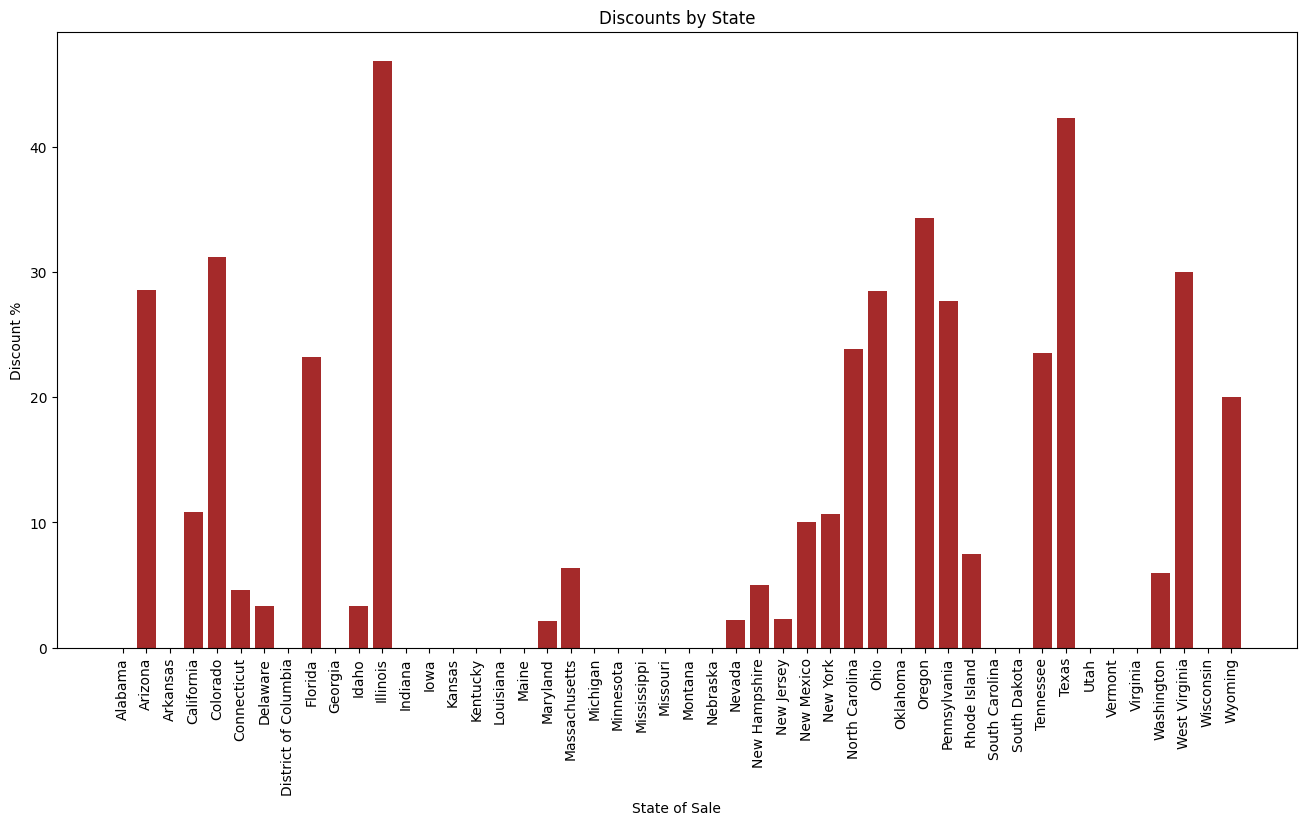

In [30]:
#The Central Region's least profitable states jointly constitute about 68% of orders for the region
#No wonder the Central Region's profits are looking so bad!

#Compare average discounts across all states to see if IL and TX stick out

df_discount_by_state = df.groupby('State')['Discount'].mean().reset_index()
df_discount_by_state['Discount'] = df_discount_by_state['Discount']*100

plt.figure(figsize=(16,8))
plt.bar(df_discount_by_state['State'], df_discount_by_state['Discount'],color = 'brown')
plt.xticks(rotation=90)
plt.title('Discounts by State')
plt.xlabel('State of Sale')
plt.ylabel('Discount %')
plt.show()

Year
2014   -3386.9952
2015   -4111.7053
2016   -5866.2762
2017   -6147.4546
Name: Profit, dtype: float64


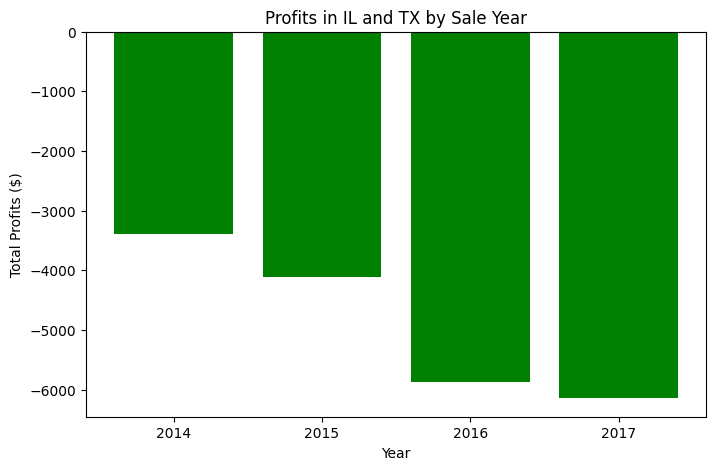

In [31]:
#Notably IL and TX have the highest mean discounts, although not drastically out of range compared to other states

#Determine total profits for Illinois and Texas across by sale year

mask = (df['State'] != 'Illinois') & (df['State'] != 'Texas')

df_only_ILTX = df.drop(df[mask].index)

yearly_profits_only_ILTX = df_only_ILTX.groupby('Year')['Profit'].sum()

print(yearly_profits_only_ILTX)

plt.figure(figsize=(8, 5))
plt.bar(yearly_profits_only_ILTX.index,yearly_profits_only_ILTX.values,color='green')
plt.title('Profits in IL and TX by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(yearly_profits_only_ILTX.index.astype(int))
plt.show()

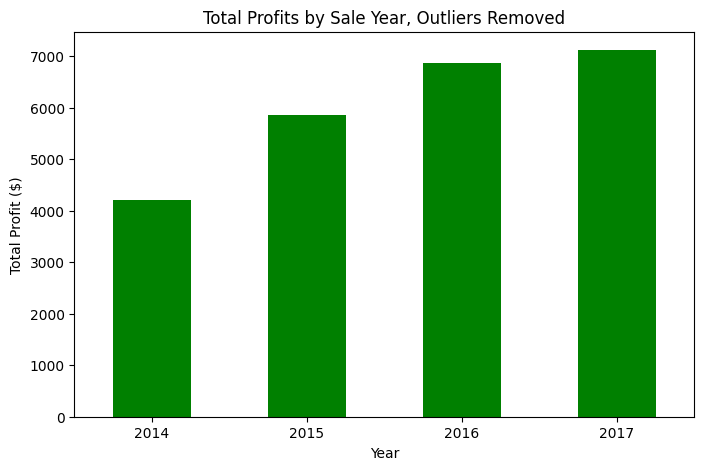

In [32]:
#Poor performance in IL and TX is an interesting observation, but it still 
#does not answer why 2015 and 2017 profits are so low compared to 2014 and 2016

#Lets circle back to our dataframe where we removed outliers and compare to the original:

#Plot profits again without outliers
yearly_profits_no_outliers = df_no_outliers.groupby('Year')['Profit'].sum()
plt.figure(figsize=(8, 5))
yearly_profits_no_outliers.plot(kind='bar', color='green')
plt.title('Total Profits by Sale Year, Outliers Removed')
plt.xlabel('Year')
plt.ylabel('Total Profit ($)')
plt.xticks(rotation=0)
plt.show()

In [33]:
#As observed above, without outliers the annual profits are less variable and tend to increase
#Perform groupings of outliers by sub-category, state, and year to see if any trends emerge 

Low_Outliers_By_SubCat = Low_Outliers.groupby('Sub-Category')['Sub-Category'].count().sort_values(ascending=False)
High_Outliers_By_SubCat = High_Outliers.groupby('Sub-Category')['Sub-Category'].count().sort_values(ascending=False)
Low_Outliers_By_State = Low_Outliers.groupby('State')['State'].count().sort_values(ascending=False)
High_Outliers_By_State = High_Outliers.groupby('State')['State'].count().sort_values(ascending=False)
Low_Outliers_By_Year = Low_Outliers.groupby('Year')['Year'].count().sort_values(ascending=False)
High_Outliers_By_Year = High_Outliers.groupby('Year')['Year'].count().sort_values(ascending=False)

print('Low Profit Outliers by Sub-Category:')
print(Low_Outliers_By_SubCat.to_string())
print('\nHigh Profit Outliers by Sub-Category:')
print(High_Outliers_By_SubCat.to_string())

print('\nLow Profit Outliers by State:')
print(Low_Outliers_By_State.to_string())
print('\nHigh Profit Outliers by State:')
print(High_Outliers_By_State.to_string())

print('\nLow Profit Outliers by Year:')
print(Low_Outliers_By_Year.to_string())
print('\nHigh Profit Outliers by Year:')
print(High_Outliers_By_Year.to_string())

Low Profit Outliers by Sub-Category:
Sub-Category
Tables         20
Bookcases       3
Chairs          1
Furnishings     1

High Profit Outliers by Sub-Category:
Sub-Category
Chairs       15
Tables        3
Bookcases     1

Low Profit Outliers by State:
State
Illinois          5
Pennsylvania      4
Arizona           2
Colorado          2
Florida           2
New York          2
North Carolina    2
Ohio              2
Tennessee         2
Texas             2

High Profit Outliers by State:
State
New York          3
Wisconsin         3
Michigan          2
Minnesota         2
Washington        2
Indiana           1
Kentucky          1
Oklahoma          1
Rhode Island      1
South Carolina    1
Vermont           1
Virginia          1

Low Profit Outliers by Year:
Year
2017    11
2015     7
2014     4
2016     3

High Profit Outliers by Year:
Year
2014    6
2015    5
2017    5
2016    3


In [34]:
#Low profit outliers are largely Tables while high outliers are mostly Chairs.
#Furthermore, 2015 and 2017 have higher instances of low outliers, 
#which explains why removing them makes annual profits look more uniform.
#With this mystery solved, lets return to the topic of low profits in IL and TX. 
#What if we had not sold products in those two states?

#Plot actual profits against what they would be if no sales were made in IL/TX
mask_ILTX = (df_no_outliers['State'] == 'Illinois') | (df_no_outliers['State'] == 'Texas')
df_no_ILTX = df_no_outliers.drop(df_no_outliers[mask_ILTX].index)

yearly_profits_no_ILTX = df_no_ILTX.groupby('Year')['Profit'].sum()

print('Profit Delta when IL, TX sales are removed: ')
print(round(yearly_profits_no_ILTX - yearly_profits_no_outliers, 2))

print('\nPercent change in profits when IL, TX sales are removed: ')
print(round(100*(yearly_profits_no_ILTX-yearly_profits_no_outliers)/yearly_profits_no_outliers,2))


Profit Delta when IL, TX sales are removed: 
Year
2014    2979.31
2015    3148.52
2016    5327.83
2017    4722.83
Name: Profit, dtype: float64

Percent change in profits when IL, TX sales are removed: 
Year
2014    70.86
2015    53.66
2016    77.63
2017    66.31
Name: Profit, dtype: float64


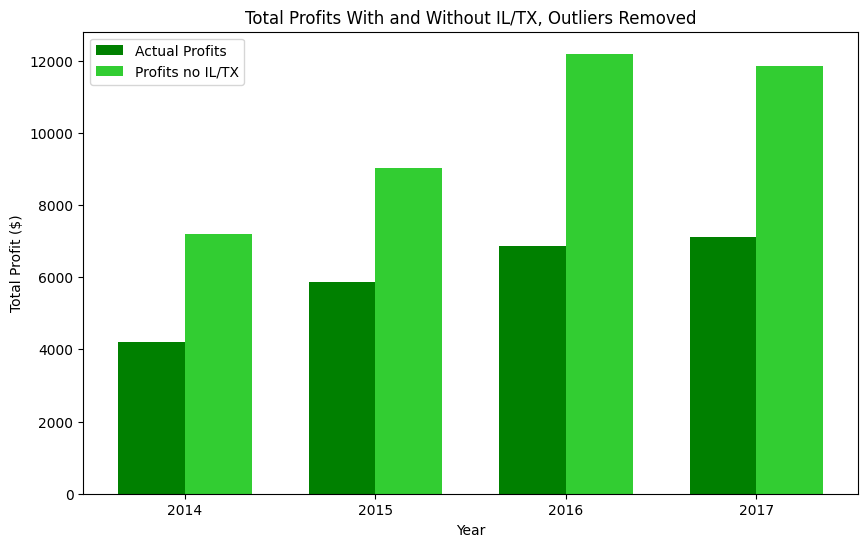

In [35]:
#Given the huge improvement in overall profits when IL and TX are eliminated, this retailer should
#consider making changes in these two particular states to cut their losses. Given that these states also
#have the highest discounts as we saw earlier, perhaps lower discounts should be considered.

#Plot bar graphs side by side for visual comparison
bar_width = 0.35
index = np.arange(4)

years = ['2014','2015','2016','2017']

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(index-bar_width/2,yearly_profits_no_outliers.values,bar_width, label='Actual Profits',color='green')
bar1 = ax.bar(index+bar_width/2,yearly_profits_no_ILTX.values,bar_width, label='Profits no IL/TX',color='limegreen')
ax.legend()
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.set_xlabel('Year')
ax.set_ylabel('Total Profit ($)')
ax.set_title('Total Profits With and Without IL/TX, Outliers Removed')
plt.show()

# ML Modeling

## Feature Engineering

In [36]:
#The preceding sections constitute the proverbial meat and potatoes of this project
#But for fun, and to hone my skills, I opted to proceed with building an ML model to predict profits

#Create additional datetime features for training
#Note we use the outlier-free dataframe to avoid overfitting

df_no_outliers['Month'] = df_no_outliers['Order Date'].dt.month
df_no_outliers['Day'] = df_no_outliers['Order Date'].dt.day
df_no_outliers['Weekday'] = df_no_outliers['Order Date'].dt.weekday
df_no_outliers['Quarter'] = df_no_outliers['Order Date'].dt.quarter

df_no_outliers = df_no_outliers.sort_values(by='Order Date') 
df_original = df_no_outliers

In [37]:
#Create Lag and Rolling features
df_no_outliers['Profit Lag'] = df_no_outliers['Profit'].shift(364)

df_no_outliers['Profit Rolling Mean'] = df_no_outliers['Profit'].rolling(window=364).mean()
df_no_outliers['Profit Rolling Sum'] = df_no_outliers['Profit'].rolling(window=364).sum()
df_no_outliers['Profit Rolling STD'] = df_no_outliers['Profit'].rolling(window=364).std()


In [38]:
#Encode categorical variables and add to Dataframe
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_no_outliers[['Region','Sub-Category','State']])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())

df_no_outliers = pd.concat([df_no_outliers, encoded_df],axis=1)
df_no_outliers = df_no_outliers.dropna()


In [39]:
#Compile features list for model training
features = df_no_outliers[['Year','Month','Quarter','Day','Weekday','Profit Lag', \
                           'Profit Rolling Mean','Profit Rolling STD','Profit Rolling Sum'] \
                            + list(encoded_df.columns)] 

#Split Training and test set data 
train_data = df_no_outliers.loc[df_no_outliers['Year']<2017]
test_data = df_no_outliers.loc[df_no_outliers['Year']==2017]

#Create training and test sets for features and targets
x_train = train_data[features.columns]
y_train = train_data['Profit'] 
x_test = test_data[features.columns]
y_test = test_data['Profit']

## Random Forest Model

In [40]:
#Set up Random Forest model and fit to training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

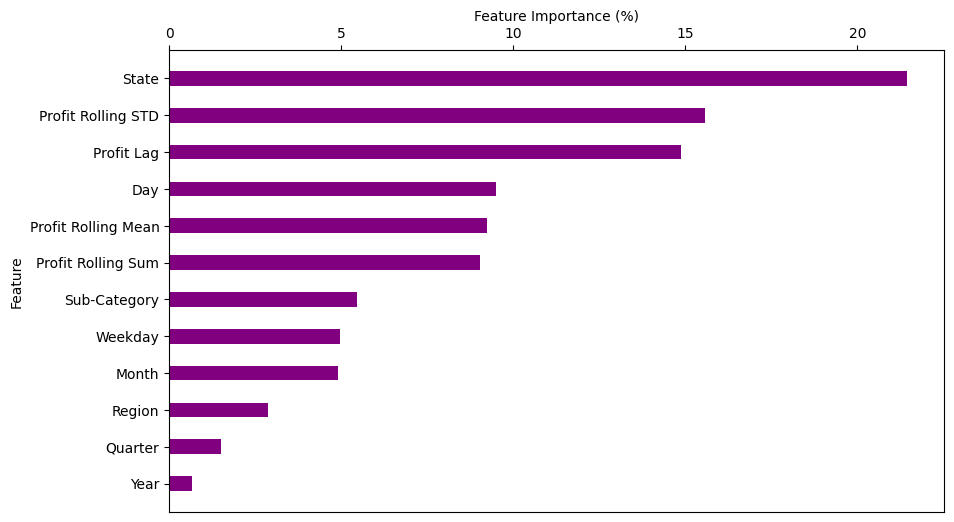

In [41]:
#Determine feature importances
features = x_train.columns
feature_importances = model.feature_importances_

#Create new importance dataframe
importance_df = pd.DataFrame({'Feature':features,'Importance':feature_importances})

#Call function to aggregate categoricals
importance_df = Aggregate_Categoricals(importance_df,'Region')
importance_df = Aggregate_Categoricals(importance_df,'State')
importance_df = Aggregate_Categoricals(importance_df,'Sub-Category')

plt.figure(figsize=(10, 6))
plt.barh(importance_df.sort_values('Importance')['Feature'],importance_df \
         .sort_values('Importance')['Importance']*100,height=0.4,color='purple')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature')

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.show()

In [42]:
#The state of sale is the most important feature for this model,
#which is unsurprising given the influence of IL and TX alone
#I would have expected sub-category to rank higher, 
#but without outliers their influence may be significantly diminished.

#Make predictions for 2017 and compare to values in test set
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {round(mse,2)}')

#Calculate RMSE
rmse = round(math.sqrt(mse),2)
profit_range = df_no_outliers['Profit'].max() - df_no_outliers['Profit'].min()

#Calculate relative RMSE to contextualize the raw value
rel_RMSE = str(round(100*rmse/profit_range,2))

print('RMSE: ' + str(rmse))
print('Relative RMSE: ' + rel_RMSE + '%')


Mean Squared Error: 7894.44
RMSE: 88.85
Relative RMSE: 11.14%


## Visualized Results

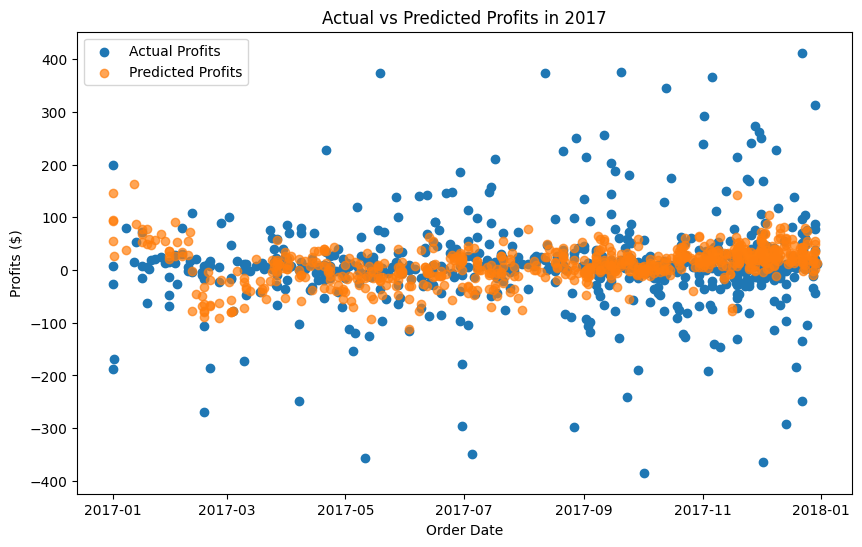

In [43]:
#After countless hours of playing around with models and features, 11.14 relative RMSE was the lowest I got
#(Adding Sales to the training features drastically improved RMSE, however I avoided this on principle)

test_data.loc[:,'Predicted Profits'] = y_pred

#Plot actual and predicted profits for 2017 as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Order Date'], test_data['Profit'], label='Actual Profits')
plt.scatter(test_data['Order Date'], test_data['Predicted Profits'], label='Predicted Profits', alpha = 0.7)
plt.xlabel('Order Date')
plt.ylabel('Profits ($)')
plt.title('Actual vs Predicted Profits in 2017')
plt.legend()
plt.show()

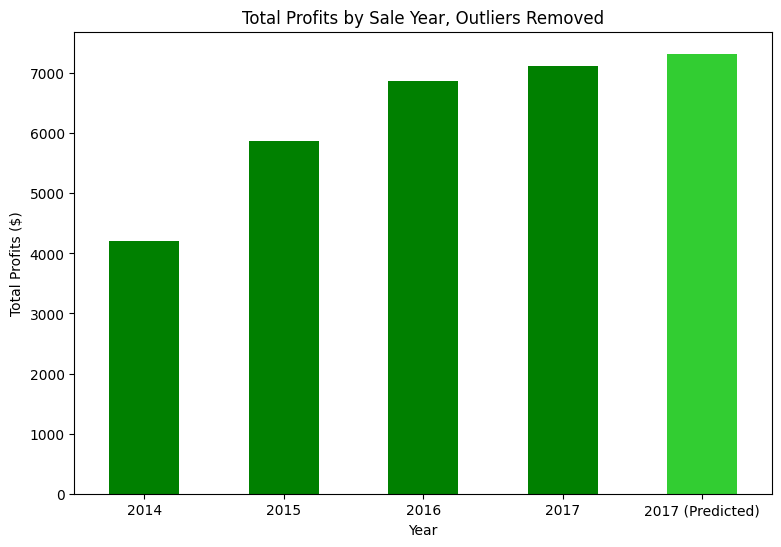

In [44]:
#The model seems to cluster toward the middle of the profit range
#The model does not seem adept at predicting values far from the mean

#Add predicted 2017 profit sum to previously defined slice
yearly_profits_no_outliers = df_original.groupby('Year')['Profit'].sum()
yearly_profits_no_outliers['2017 (Predicted)'] = test_data['Predicted Profits'].sum()

colors = ['green','green','green','green','limegreen']

#Plot profits with prediction for 2017
plt.figure(figsize=(9, 6))
yearly_profits_no_outliers.plot(kind='bar', color=colors)
plt.title('Total Profits by Sale Year, Outliers Removed')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(rotation=0)
plt.show()